In [2]:
import os
import torch
import ot

parent_path=%pwd  
os.chdir(parent_path)
from lib.opt import *
from lib.gromov_test import *   

import numpy as np 
import numba as nb
import warnings
import time
from ot.backend import get_backend, NumpyBackend
from ot.lp import emd


In [ ]:
# run time 
import time
start=0
n_list=np.array([5,10,100,500,1000,2000,5000,10000])
#n_list=[5e3,1e4]
n_list=np.array(n_list,dtype=np.int64)
repeat_num=3
Lambda_list=np.array([0.2,1.0,10.0])
time_list=torch.load('result/alg/time_list.pt')
# time_list={}
# time_list['pgw_v1']=np.zeros((len(n_list),len(Lambda_list),repeat_num))
# time_list['pgw_v2']=np.zeros((len(n_list),len(Lambda_list),repeat_num))
# time_list['pgw_prim']=np.zeros((len(n_list),len(Lambda_list),repeat_num))
# time_list['pgw_sinkhorn']=np.zeros((len(n_list),len(Lambda_list),repeat_num))

for (n_idx,n) in enumerate(n_list[start:]):
    n_idx+=start
    print('n is',n)
    for (Lambda_idx,Lambda) in enumerate(Lambda_list):
        for repeat in range(repeat_num):
            print('repeat',repeat,end='\r')
            #print('repeat',repeat)
            np.random.seed(1)
            m=n+10
            X=np.random.rand(n,1)*2
            Y=np.random.rand(m,1)*2
            C1=cost_matrix_d(X,X)
            C2=cost_matrix_d(Y,Y)
            
            p=np.ones(n)
            p=p/m
            q=np.ones(m)
            q=q/m
            
            print('v2',end='\r')
            time1=time.time()
            Gamma2,log2=partial_gromov_v2(C1, C2, p, q, Lambda=Lambda, nb_dummies=1, G0=None,thres=1, numItermax=100*n, tol=1e-5,log=False, verbose=False)
            time2=time.time()
            time_list['pgw_v2'][n_idx,Lambda_idx,repeat]=time2-time1
            if repeat==0 and Lambda_idx ==0:
                print('time v2 is', time2-time1)
                #print('iter number ',iter_num)

           
            
            mass=np.sum(Gamma2)
            mass=np.min((mass,p.sum(),q.sum()))

            print('prim',end='\r')
            time1=time.time()
            Gamma3=partial_gromov_wasserstein(C1, C2, p, q, m=mass, nb_dummies=1, G0=None,thres=1, numItermax=100*n, tol=1e-5,log=False, verbose=False)
            time2=time.time()
            time_list['pgw_prim'][n_idx,Lambda_idx,repeat]=time2-time1
            if repeat==0 and Lambda_idx==0:
                print('time prim is', time2-time1)
                #print('iter_num is',iter_num)
            
            print('v1',end='\r')
            time1=time.time()
            Gamma1,log1=partial_gromov_v1(C1, C2, p, q, Lambda=Lambda, nb_dummies=1, G0=None,thres=1, numItermax=100*n, tol=1e-5,log=False, verbose=False)
            time2=time.time()
            time_list['pgw_v1'][n_idx,Lambda_idx,repeat]=time2-time1
            if repeat==0 and Lambda_idx ==0:
                print('time v1 is', time2-time1)
                #print('iter number ',iter_num)



            if n<2000:
                print('sinkhorn',end='\r')
                time1=time.time()
                ot.partial.entropic_partial_gromov_wasserstein(C1, C2, p, q, reg=0.1, m=mass, G0=None, numItermax=1000, tol=1e-05, log=False, verbose=False)
                time2=time.time()            
                time_list['pgw_sinkhorn'][n_idx,Lambda_idx,repeat]=time2-time1
            
            torch.save(time_list,'result/alg/time_list.pt')  

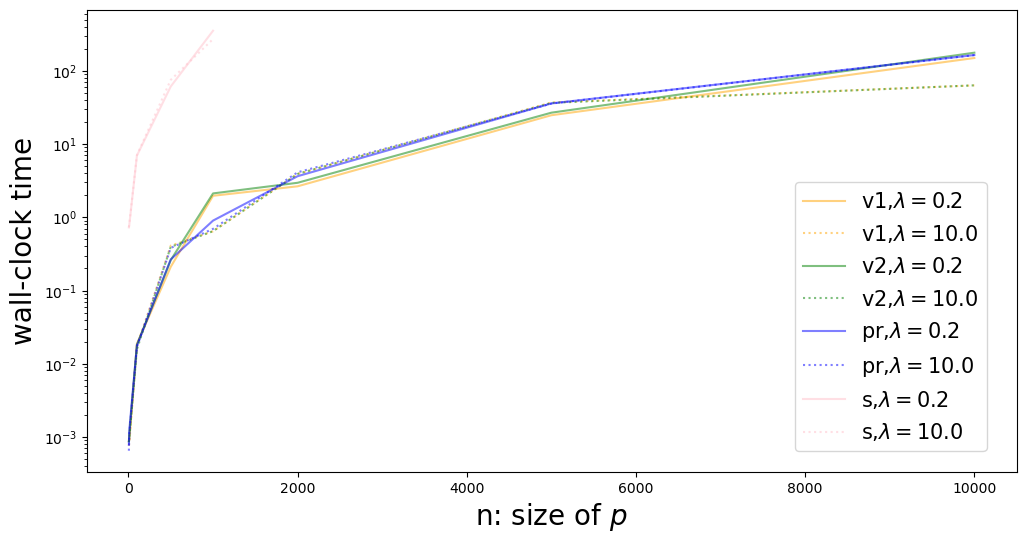

In [36]:
# wall clock time test 
import numpy as np
import torch
import matplotlib.pyplot as plt

n_list=np.array([5,10,100,500,1000,2000,5000,10000])
#n_list=[5e3,1e4]
n_list=np.array(n_list,dtype=np.int64)
repeat_num=3
Lambda_list=np.array([0.2,1.0,10.0])

time_list=torch.load('result/alg/time_list.pt')
time_v1=time_list['pgw_v1'] 
time_v2=time_list['pgw_v2']
time_prim=time_list['pgw_prim']
time_sinkhorn=time_list['pgw_sinkhorn']

time_v1_mean=np.mean(time_v1,2)
time_v2_mean=np.mean(time_v2,2)
time_prim_mean=np.mean(time_prim,2) 
time_sinkhorn_mean=np.mean(time_sinkhorn,2) 


fig, ax = plt.subplots(figsize=(12, 6))

# Plotting both error lists
for (method,color,time_mean) in zip(['v1','v2','pr','s'],['orange','green','blue','pink'],[time_v1_mean,time_v2_mean,time_prim_mean,time_sinkhorn_mean]):
    for (Lambda_idx,Lambda,style) in zip(np.array([0,2]),Lambda_list[[0,2]],['-',':']):
        if method !='s':
            ax.semilogy(n_list[:], time_mean[:,Lambda_idx],color=color,linestyle=style,alpha=0.5,label=method+f',$\lambda={Lambda}$')
        else:
            ax.semilogy(n_list[0:5], time_mean[0:5,Lambda_idx],color=color,alpha=0.5,linestyle=style,label=method+f',$\lambda={Lambda}$')


ax.set_xlabel('n: size of $p$',fontsize=20)
ax.set_ylabel('wall-clock time',fontsize=20)
#ax.set_title('Plot of Relative Error vs Size of $\mu$ for Different $\lambda$ Values')
ax.legend(bbox_to_anchor=(.75, 0.65),fontsize=15, loc="upper left")
plt.savefig('result/alg/time.png',dpi=200)
plt.savefig('result/alg/time.pdf',dpi=200)
plt.show()
